In [1]:
from cgkit import graph
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import statsmodels.api as sm

colors = {'d': 'orange',
         '0': 'purple',
         '1': 'red',
         '2': 'green',
         '3': 'blue',
         '4': 'C',
         '5': 'gray',
         '6':'tan',
         '7': 'black',
         '8': 'navy',
         '9':'aqua'}

In this notebook we will add some bias to each of the structural equations and investigate the effects on the actual parameter estimates in our model for $y$.

In [2]:
bound = np.linspace(0.1, 10, 100)

G = graph.GraphStructure(continous = 5,
                         dummies = 1,
                         density = .5, 
                         seed = 2)

outdata = {i:list() for i in G.graph.nodes}
upper = {i:list() for i in G.graph.nodes}
lower = {i:list() for i in G.graph.nodes}

for i in outdata, upper, lower:
    del i['c0']

for l,h in zip([-x for x in bound], bound):
    
    G = graph.GraphStructure(continous = 5,
                             dummies = 1,
                             density = .5, 
                             seed = 2)

    
    G.bias_space = lambda: np.random.uniform(l, h)
    
    S = graph.CausalSystem(G, 3, 1000)
    data = S.step_all()
    
    true_vals = graph.find_true_values(G, kind = 'weights')

    ols = sm.OLS(data['c0'], data.drop(['c0', 'idx'], axis = 1))
    ols_result = ols.fit()   

    res = ols_result.params
    std = ols_result.HC0_se
    
    for r in res.keys():        
        outdata[r].append(res[r] - true_vals[r])        
        upper[r].append(res[r] + 1.96*std[r] - true_vals[r])
        lower[r].append(res[r] - 1.96*std[r] - true_vals[r])

Text(0.5,1,'$\\hat{\\theta} - \\theta$ for increasing variance in structural biases')

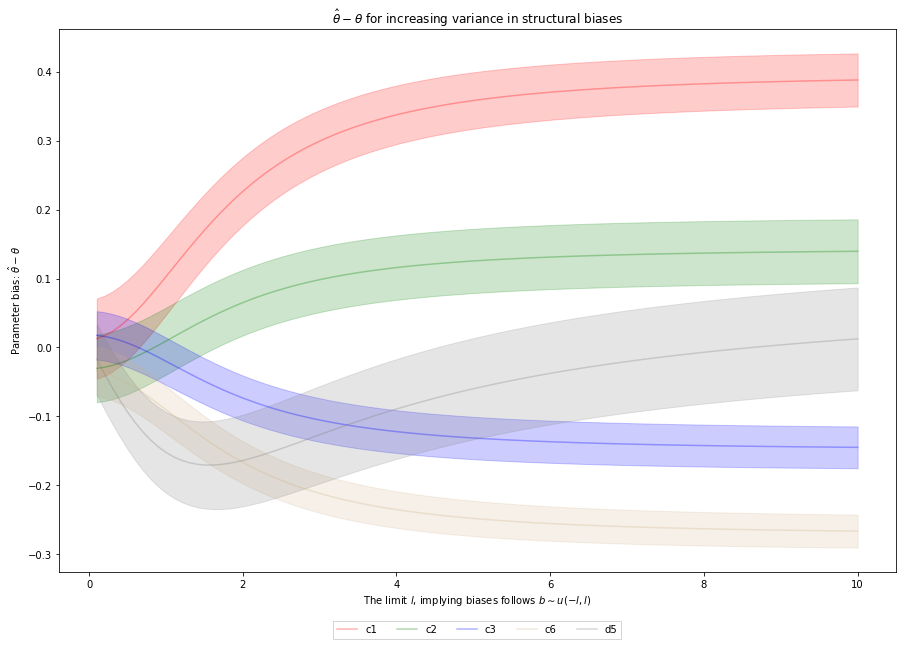

In [4]:
fig, ax = plt.subplots(figsize=(15,10))

for var in sorted(outdata.keys()):
    ax.plot(bound, outdata[var], color = colors[var[1]], alpha = 0.3, label = var)
    ax.fill_between(bound, upper[var], lower[var],
    alpha=0.2, edgecolor=colors[var[1]], facecolor=colors[var[1]])
    
#ax.set_xscale("log", nonposx='clip')    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=False, shadow=False, ncol=5)

ax.set_xlabel("The limit $l$, implying biases follows $b\sim u(-l,l)$")
ax.set_ylabel(r"Parameter bias: $\hat{\theta} - \theta$")
ax.set_title(r"$\hat{\theta} - \theta$ for increasing variance in structural biases")